<a href="https://colab.research.google.com/github/cbarlow-corelationinc/troubled_loan_detection/blob/main/TroubledLoanDetection_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Troubled Loan Detection with [Deep Learning](#https://en.wikipedia.org/wiki/Deep_learning)

<a id='introduction'></a>
## Introduction##
This [Jupyter notebook](https://jupyter.org/) is an example of how "Deep Learning" (a branch of machine learning that uses Artificial Neural Networks) can analyze features and labels of a training set to try to "learn" a set of weights for being able to "predict" the labels in additional data that was not used during training. For machine learning to work, we are making some important assumptions that may not be true for every use case.  In particular, we are hypothesizing (a) that the outputs <i>can</i> be predicted from the inputs, and (b) that the available data is sufficiently informative to learn the relationship between the inputs and outputs.  These two assumptions largely depend on the input features we select and the amount of representational data we can collect.

For this particular example we will examine over 30 loan features on roughly 75,000 loans that have all been labeled as 1 ("bad") or 0 ("good"), based on whether or not they were charged off within six months of the date the data was examined.  The methods used employ the [keras](https://keras.io/) library for [Python](https://en.wikipedia.org/wiki/Python_(programming_language)).  This is an example of [supervised learning](https://en.wikipedia.org/wiki/Supervised_learning) (we provide the "ground truth" labels for the training data), using various models.


<b><i>Only run the following cell if you are running on Google Colab environment!<i></b> This cell is intended to install any Python libraries that are missing from the default environment in Google Colab and to pull down the necessary utility Python code and data files from Git Hub.

In [1]:
import sys

if sys.platform.startswith('linux'):
    # Extra imports for pulling zip file from Carl GitHub repository.
    from datetime import datetime
    import requests, zipfile, io

    # Install additional Python libraries that are missing from the default environment in Google Colab
    %pip install scikit-plot

    # Remove folders that may be left over from previous runs
    !rm -f datasets/*
    !rmdir datasets
    !rm -f helper_code/*
    !rmdir helper_code
    !rm -f models/*
    !rmdir models

    # Get necessary Python code and data files from Git Hub repository
    r = requests.get( 'https://raw.github.com/cbarlow-corelationinc/troubled_loan_detection/main/TroubledLoanDetectionFiles.zip')
    r.status_code
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
    !ls -Abl

rmdir: failed to remove 'datasets': No such file or directory
rmdir: failed to remove 'helper_code': No such file or directory
rmdir: failed to remove 'models': No such file or directory
total 36
-rw-r--r-- 1 root root 10803 Feb 17 20:29 cb3_ann_utils.py
-rw-r--r-- 1 root root  2646 Feb 17 20:29 cb3_email_util.py
drwxr-xr-x 1 root root  4096 Feb 16 16:35 .config
drwxr-xr-x 2 root root  4096 Feb 17 20:29 datasets
drwxr-xr-x 2 root root  4096 Feb 17 20:29 helper_code
drwxr-xr-x 2 root root  4096 Feb 17 20:29 models
drwxr-xr-x 1 root root  4096 Feb 16 16:35 sample_data


<a id='imports'></a>
## Import Necessary Packages ##

First, let's run the cell below (put your cursor in the cell and press Shift-Enter) to import all the packages that you will need.
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python. 
- [pandas](https://pandas.pydata.org/) is a data analysis library.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [seaborn](https://seaborn.pydata.org/) is a data visualization library based on matplotlib.
- [scikitplot](https://anaconda.org/conda-forge/scikit-plot) is yet another plotting library.
- [sklearn](https://scikit-learn.org/stable/) is a collection of algorithms for classification, regression, and clustering.
- [keras](https://pypi.org/project/Keras/) is a high level neural network library for deep learning applications.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.

In [2]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

# Set global figure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default seaborn plotting style
sns.set_style('white')

And some additional imports we will need for these models and metrics.

In [3]:
#import tensorflow.python.util.deprecation as deprecation

from datetime import datetime
from math import log10
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Helper code to plot confusion matrix
from helper_code import mlplots as ml

from cb3_ann_utils import describe_datasets, build_compile_fit_model, \
    my_f1_score, cb3_calculateResults1, cb3_calculateResults2, cb3_displayResults
from cb3_email_util import email_result, email_completion_notice

sns.set(style='white', context='notebook', palette='deep')
#deprecation._PRINT_DEPRECATION_WARNINGS = False
%matplotlib inline

print("Done importing required modules.")

Done importing required modules.


Return to [top](#introduction)
<a id='load_data'></a>
## Load the Data
The Pandas library has a read_csv() function that can read a CSV file directly into a Pandas DataFrame. This is particularly easy if the first row of the CSV file has labels and if those labels do not contain spaces. We can even specify a column that will act as an index and not as a normal column, as seen here with the LOAN_SERIAL column.

In [4]:
# Read CSV data
loan_data = pd.read_csv('datasets/AnonymousLoans20190930OregonStateFull.csv', index_col = 'LOAN_SERIAL')
loan_data.head()

,LN_TYPE_CATEGORY,CREDIT_LIMIT,COBORROWER_COUNT,ORIGINAL_TERM_IN_MONTHS,BALANCE,MONTHLY_PMT,INTEREST_RATE,DQ_DAYS,STILL_MISSED_FIRST_PMT,HAS_COLLATERAL,AGE_IN_DAYS,MEMBERSHIP_DAYS,PMT_COUNT_MADE,PMT_COUNT_DQ_UNDER_30,PMT_COUNT_DQ_30_TO_59,PMT_COUNT_DQ_60_TO_89,PMT_COUNT_DQ_90_TO_119,PMT_COUNT_DQ_120_AND_UP,MONTHLY_INCOME,MONTHLY_EXPENSE,LR_AMOUNT,SCORE,AGE_OF_SCORE,AGGR_SHARE_COUNT,AGGR_SHARE_BAL,DD_CHANGE,CREDIT_LIMIT_INCREASE_COUNT,OFF_AUTO_PAY_COUNT,CHARGE_OFF_DATE,BINARY_STATUS
LOAN_SERIAL,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
42558,CE,0.00,0,74,6003.52,200.41,2.59,0,0,1,13550,3573,24,0,0,0,0,0,0.0,0.0,0.0,218,171,4,260.01,1769.83,0,0,NaN,0
42601,CC,15000.00,0,0,48.04,25.00,9.75,0,0,0,11713,4506,24,0,0,0,0,0,0.0,0.0,0.0,0,0,2,15717.72,36238.45,0,0,NaN,0
37695,CE,0.00,0,73,8889.52,211.55,5.09,0,0,1,26437,4963,25,0,2,0,0,0,0.0,0.0,0.0,0,0,2,133.08,0.00,0,0,NaN,0
38623,LC,5000.00,0,0,0.00,0.00,9.00,0,0,0,22122,4863,1,0,0,0,0,0,0.0,0.0,0.0,0,0,5,4841.67,-2426.46,0,0,NaN,0
124753,CE,33719.32,1,85,28356.22,465.44,3.99,0,0,1,20984,4371,15,0,0,0,0,0,0.0,0.0,0.0,229,487,2,21170.88,1023.90,0,0,NaN,0


Return to [top](#introduction)
<a id='explore_data'></a>
## Exploratory Data Analysis (EDA) (Optional) ##
Now you can optionally display additional information about the data, such as the keys/feature column names, how many non-null values there are for each, and the data type (float64):

In [5]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75271 entries, 42558 to 109035
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   LN_TYPE_CATEGORY             75271 non-null  object 
 1   CREDIT_LIMIT                 75271 non-null  float64
 2   COBORROWER_COUNT             75271 non-null  int64  
 3   ORIGINAL_TERM_IN_MONTHS      75271 non-null  int64  
 4   BALANCE                      75271 non-null  float64
 5   MONTHLY_PMT                  75271 non-null  float64
 6   INTEREST_RATE                75271 non-null  float64
 7   DQ_DAYS                      75271 non-null  int64  
 8   STILL_MISSED_FIRST_PMT       75271 non-null  int64  
 9   HAS_COLLATERAL               75271 non-null  int64  
 10  AGE_IN_DAYS                  75271 non-null  int64  
 11  MEMBERSHIP_DAYS              75271 non-null  int64  
 12  PMT_COUNT_MADE               75271 non-null  int64  
 13  PMT_COUNT_D

Return to [top](#introduction)
<a id='encode'></a>
## Encode Categorical Features ##
Now do a one-hot label encoding on the categorical feature LN_TYPE_CATEGORY and split the dataframe into loan_features and loan_labels, where the label comes from the BINARY_STATUS column, where 1 indicates a loan that gets charged off in next six months and 0 inidicates the majority case where the loan is <i>not</i> charged off in the next six months.

In [6]:
ln_type_cat = loan_data[['LN_TYPE_CATEGORY']].astype(CategoricalDtype(["CC", "CE", "LC", "OE"]))
ln_type_cat = pd.get_dummies(ln_type_cat, prefix='LN_TYPE_CAT', drop_first=True)
ln_type_cat.head()

categorical_features = ln_type_cat

# Extract numerical features
#numerical_features = loan_data[['CREDIT_LIMIT', 'COBORROWER_COUNT', 'ORIGINAL_TERM_IN_MONTHS', 'BALANCE', 'MONTHLY_PMT', 'INTEREST_RATE', \
#                               'DQ_DAYS', 'STILL_MISSED_FIRST_PMT', 'HAS_COLLATERAL', 'AGE_IN_DAYS', 'MEMBERSHIP_DAYS', 'PMT_COUNT_MADE', \
#                               'PMT_COUNT_DQ_30_TO_59', 'PMT_COUNT_DQ_60_TO_89', 'PMT_COUNT_DQ_90_TO_119', \
#                               'PMT_COUNT_DQ_120_AND_UP', 'MONTHLY_INCOME', 'MONTHLY_EXPENSE', 'LR_AMOUNT', 'SCORE', 'AGE_OF_SCORE', \
#                               'AGGR_SHARE_COUNT', 'AGGR_SHARE_BAL', 'DD_CHANGE', 'CREDIT_LIMIT_INCREASE_COUNT', 'OFF_AUTO_PAY_COUNT']]
# using only 11 of original 30 features
numerical_features = loan_data[['DQ_DAYS', 'AGGR_SHARE_BAL', 'PMT_COUNT_MADE', 'MONTHLY_PMT', 'PMT_COUNT_DQ_30_TO_59', \
                                'CREDIT_LIMIT', 'INTEREST_RATE', 'PMT_COUNT_DQ_90_TO_119', 'SCORE', \
                                'COBORROWER_COUNT', 'MONTHLY_EXPENSE']]
#loan_features = pd.concat([categorical_features, numerical_features], axis=1)
loan_features = numerical_features

loan_labels = loan_data['BINARY_STATUS']
frame = { 'BINARY_STATUS': loan_labels } 
loan_labels_df = pd.DataFrame(frame)

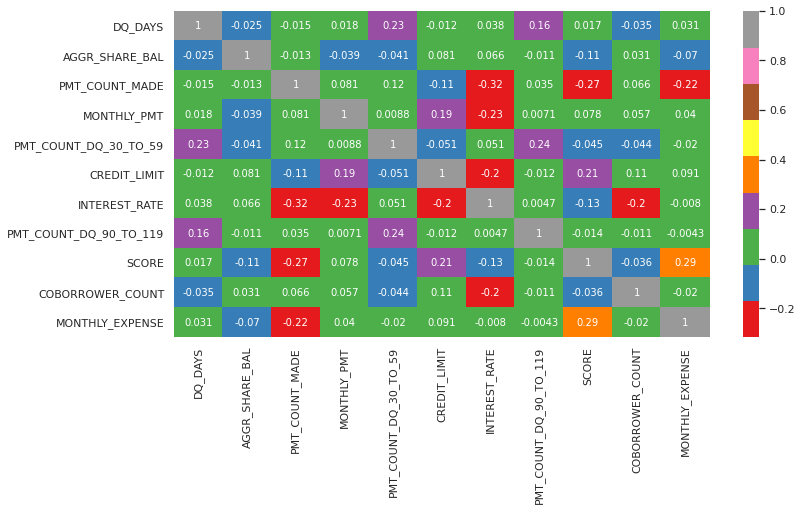

In [7]:
cor = loan_features.corr()
plt.figure(figsize=(12,6))
sns.heatmap(cor,cmap='Set1',annot=True)

Return to [top](#introduction)
<a id='split_and_normalize'></a>
## Split and Normalize the Data Set
Now let's try a Support Vector Machine (SVM). We will start over from the original loan_features (this time we will use a one-hot encoding of LN_TYPE_CATEGORY) and loan_labels, and split them into train, dev, and test sets. We will make the training set be 80% of the total loans, and we will divide the remaining loans equally between the dev and test sets.

In [8]:
# Extract and encode categorical features
rs = 31
np.random.seed(rs)

# Split the data up in train and dev sets
X_train, X_test, y_train, y_test = train_test_split(loan_features, loan_labels_df, train_size=0.8)
# Further split dev data into dev and test sets
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.50)

# Normalize the data
train_mean = X_train.mean(axis=0)
train_std = X_train.std(axis=0)
train_std = np.where(train_std==0.0, 1.e-8, train_std) # avoid divide by zero error
X_train -= train_mean
X_train /= train_std
# scale dev data and test data based on train data mean and standard deviation!
X_dev -= train_mean
X_dev /= train_std
X_test -= train_mean
X_test /= train_std
    
n = X_train.shape[1]  # feature count
#describe_datasets(X_train, y_train, X_dev, y_dev, X_test, y_test, n)
describe_datasets(X_train, y_train, X_dev, y_dev, X_test, y_test, n)


11 features
Total size of dataset:  75271 loans ( 74786  good;  485  bad)
Size of Original Training Set:  60216 loans ( 59829  good;  387  bad)
Size of Dev Set:  7527 loans ( 7484  good;  43  bad)
Size of Test Set:  7528 loans ( 7473  good;  55  bad)



Return to [top](#introduction)
<a id='oversample_minority'></a>
## Oversample the Minority Case (Optional) ##
This section is optional.  If you choose, you can skip to the section where you [prepare the model](#prepare_model).

The dataset is very skewed towards "good" loans (over 98%!).  One technique that is prevalent for improving the training on the dataset is to "oversample" the minority set ("bad" loans) so that they are better represented, although this can make overfitting more likely, so guard against that with regularization, etc.

In [9]:
X=pd.concat([X_train,y_train],axis=1)

good_loans=X[X.BINARY_STATUS==0]
bad_loans=X[X.BINARY_STATUS==1]

# upsample minority
bad_loans_oversampled = resample(bad_loans,
                          replace=True, # sample with replacement
                          n_samples=len(good_loans)//4, # match one fourth of number in majority class
                          random_state=rs) # reproducible results

# combine majority and upsampled minority
oversampled = pd.concat([good_loans, bad_loans_oversampled])
# reshuffle the dataset
oversampled = oversampled.sample(frac=1).reset_index(drop=True)
X_train = oversampled.iloc[:,:-1]
#y_train = oversampled.iloc[:,-1]
y_train = oversampled[['BINARY_STATUS']].copy()
del oversampled  # delete combined, oversampled training data now that it is divided again into X_train and y_train

# check new class counts
print("\nOversampling minority case results in the following new distribution of labels in test data:")
print(y_train.BINARY_STATUS.value_counts())


Oversampling minority case results in the following new distribution of labels in test data:
0    59829
1    14957
Name: BINARY_STATUS, dtype: int64


Return to [top](#introduction)
<a id='prepare_model'></a>
## Prepare the Model by Setting the Hyperparameters ##
Now set the hyperparamters, including how many times to iterate through the learning process, setting some of the hyperparameters randomly.  Set iterateCount = 1 if you just want to train on the data one time with the assigned hyperparameter values.

In [10]:
# Now set hyperparameters before you build, compile, and fit model
learning_rate = 0.0777
regularization_factor = 0.0000018

hidden_layer_count = 3
units_per_hidden_layer = 5
send_progress_emails = False  # Emails sent to carl.barlow.iii@gmail.com
print_summary = True   # display network architecture

epochs = 5
batch_size=256
batch_normalization=True
verbose = 0     # 0 = silent; 1 = progress bar; 2 = one line per epoch

beta_1 = 0.9    # hyperparameter for Adam optimization
beta_2 = 0.999  # hyperparameter for Adam optimization
epsilon = 1.e-8 # hyperparameter for Adam optimization to avoid divide by zero
decay = 0.0     # learning rate decay
amsgrad = False
loss_function='binary_crossentropy'  # appropriate for binary classification problems

iterateCount = 50  # set to number greater than 1 if wanting to tune learning_rate, regularization_factor, and units_per_hidden_layer
lr_ten_min_exp = log10(0.030)    # choose learning rates from 0.030 to...
lr_ten_max_exp = log10(0.120)    # ...0.120, chosen uniformly along log scale
rf_ten_min_exp = log10(0.0000001)  # choose regularization_factor from 0.0000001 to...
rf_ten_max_exp = log10(0.0000300)  # ...0.0000300, chosen uniformly along log scale
hu_min = 3      # choose units_per_hidden_layer integer from 8 to...
hu_max = 12     # ...14 (inclusive) chosen uniformly in range

print("\nHyperparameters have been set.")


Hyperparameters have been set.


Return to [top](#introduction)
<a id='iterate'></a>
## Iteratively Build, Compile, and Fit (train) the Model ##
Now iterate through various random values for learning rate, regularization factor, and hidden units per layer to find best combination of these. In this case, we will use the F1 score of the dev set as the metric.  Careful: if you use the dev set too much to tune your hyperparameters, you can overfit your dev set, as will be evidenced by worse performance against the test set.  Can be useful to use a course-to-fine approach to narrow in on best values.

In [11]:
best_lr = None
best_units_per_hidden_layer = None
best_rf = None

best_f1 = 0.0
best_model = None
best_history = None

startTime = datetime.now()
print("Start time: ", startTime)
for i in range(iterateCount):
    if (i % 10 == 0):     # periodically show progress as models are trained
        print("\nStarting iteration ", i)
        timeElapsed = datetime.now() - startTime
        print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))
        
    if iterateCount>1:
        learning_rate = 10**np.random.uniform(lr_ten_min_exp,lr_ten_max_exp)          # random learning_rate distributed uniformly on a logarithmic scale
        regularization_factor = 10**np.random.uniform(rf_ten_min_exp,rf_ten_max_exp)  # random regularization_factor distributed uniformly on a logarithmic scale
        units_per_hidden_layer = np.random.randint(hu_min,hu_max+1)                   # units uniformly set to integer from 18 to 22 inclusive
    
    # This is the line that really does the learning.  It is only inside a loop for tuning hyperparameters
    model, history = build_compile_fit_model(X_train, y_train, validation_data=(X_dev, y_dev), feature_count=n, regularization_factor=regularization_factor, 
                                             hidden_layer_count=hidden_layer_count, units_per_hidden_layer=units_per_hidden_layer,  
                                             lr=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, decay=decay,  amsgrad=amsgrad, 
                                             loss_function=loss_function, epochs=epochs, batch_size=batch_size, 
                                             batch_normalization=batch_normalization, verbose=verbose) 

    f1 = my_f1_score(X_dev, y_dev, model)  # use instead of sklearn.metrics.f1_score(y_dev, y_pred) 
    if (i==0 or f1>best_f1):  # save off and display details if this is best f1 score so far
        best_f1 = f1
        best_lr = learning_rate
        best_rf = regularization_factor
        best_units_per_hidden_layer = units_per_hidden_layer
        best_model = model
        best_history = history
        
        print("\nOn iteration ", i)
        print("Best learning_rate: ", best_lr)
        print("Best regularization_factor: ", best_rf)
        print("Best units_per_hidden_layer: ", best_units_per_hidden_layer)
        print("Best dev set f1 score: ", best_f1)
        if send_progress_emails:
            email_result(i, best_lr, best_rf, best_units_per_hidden_layer, best_f1)
        model.save("./models/model.h5")
        print("Saved model to disk")
        
timeElapsed = datetime.now() - startTime
print('\nFinished!  Total time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))
if send_progress_emails:
    email_completion_notice()

learning_rate = best_lr
regularization_factor = best_rf
units_per_hidden_layer = best_units_per_hidden_layer
model = best_model
history = best_history

Start time:  2021-02-17 20:30:21.266599

Starting iteration  0
Time elapsed (hh:mm:ss.ms) 0:00:00.000595

On iteration  0
Best learning_rate:  0.08746832448072614
Best regularization_factor:  2.8245092003899936e-06
Best units_per_hidden_layer:  9
Best dev set f1 score:  0.14453125
Saved model to disk

On iteration  1
Best learning_rate:  0.033465609774781455
Best regularization_factor:  5.231712817572374e-06
Best units_per_hidden_layer:  9
Best dev set f1 score:  0.2525597269624573
Saved model to disk

On iteration  2
Best learning_rate:  0.04020187767645663
Best regularization_factor:  1.523007353329621e-07
Best units_per_hidden_layer:  6
Best dev set f1 score:  0.27419354838709675
Saved model to disk

On iteration  3
Best learning_rate:  0.06673230077850652
Best regularization_factor:  2.3037026189915635e-06
Best units_per_hidden_layer:  11
Best dev set f1 score:  0.40236686390532544
Saved model to disk

On iteration  7
Best learning_rate:  0.0338781393624877
Best regularization_fact

Return to [top](#introduction)
<a id='summarize'></a>
## Summarize the Results ##
Display summary of the selected network architecture (optional), and display various statistics about the performance of the best model found during the iterations.

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 3)                 36        
_________________________________________________________________
batch_normalization_21 (Batc (None, 3)                 12        
_________________________________________________________________
dense_29 (Dense)             (None, 3)                 12        
_________________________________________________________________
batch_normalization_22 (Batc (None, 3)                 12        
_________________________________________________________________
dense_30 (Dense)             (None, 3)                 12        
_________________________________________________________________
batch_normalization_23 (Batc (None, 3)                 12        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                

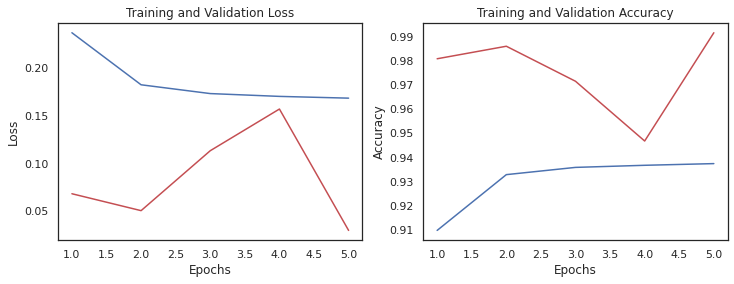

Final Training Set accuracy:  0.919089138507843


In [12]:
# optionally summarize the network architecture
if (print_summary):
    model.summary()
       
print("Best learning rate: ", learning_rate)
print("Best regularization_factor: ", regularization_factor)
print("Best units_per_hidden_layer: ", units_per_hidden_layer)
print("Best dev set f1 score: ", best_f1)

history_dict = history.history
train_loss = history_dict['loss']
dev_loss = history_dict['val_loss']
# Breaking change in Keras 2.3.0 changed key in history from 'acc' to 'accuracy' and from 'val_acc' to 'val_accuracy'.
train_acc = history_dict['accuracy']
dev_acc = history_dict['val_accuracy']
epochs = range(1, len(dev_loss) + 1)

# Now display two graphs side by side to compare loss and accuracy for training vs. validation set
fig, (loss_axis, acc_axis) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
loss_axis.plot(epochs, train_loss, 'b', label='Training loss')
loss_axis.plot(epochs, dev_loss, 'r', label='Validation loss')
loss_axis.set_title('Training and Validation Loss')
loss_axis.set_xlabel('Epochs')
loss_axis.set_ylabel('Loss')

acc_axis.plot(epochs, train_acc, 'b', label='Training accuracy')
acc_axis.plot(epochs, dev_acc, 'r', label='Validation accuracy')
acc_axis.set_title('Training and Validation Accuracy')
acc_axis.set_xlabel('Epochs')
acc_axis.set_ylabel('Accuracy')
plt.show()

final_train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
print("Final Training Set accuracy: ", final_train_acc)

Using the best model found, make predictions on the dev and test set, and output different measurements, including a confusion matrix plot.


Results for Dev Set:
Accuracy:  0.9914972764713698
Precision:  0.3670886075949367
Recall:  0.6744186046511628
F1 Score:  0.47540983606557374


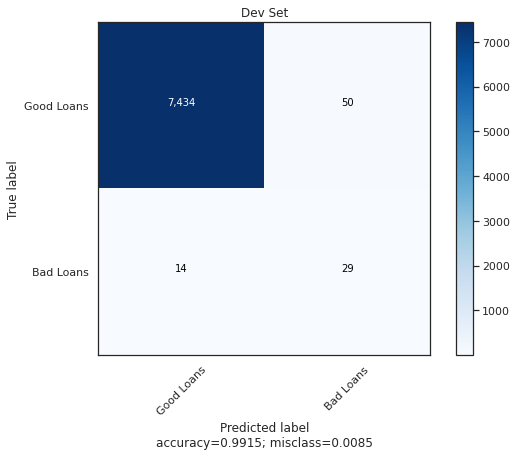


Results for Test Set:
Accuracy:  0.9921625929861849
Precision:  0.47435897435897434
Recall:  0.6727272727272727
F1 Score:  0.556390977443609


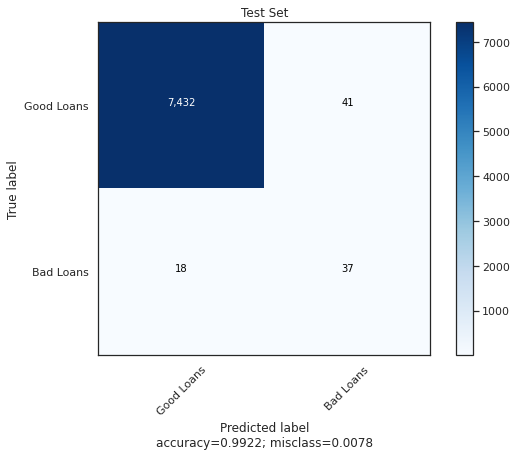

In [15]:
# Now make predictions on dev data
y_pred_dev = model.predict(X_dev)
y_pred_dev[y_pred_dev>=0.5] = 1
y_pred_dev[y_pred_dev<0.5] = 0
y_dev_numpy = y_dev.to_numpy()

(tp, tn, fp, fn) = cb3_calculateResults1(y_pred_dev, y_dev_numpy)
(accuracy, precision, recall, f1, cm) = cb3_calculateResults2(tp, tn, fp, fn)
cb3_displayResults(accuracy, precision, recall, f1, cm, "Dev Set")

# Now make predictions on test data
y_pred_test = model.predict(X_test)
y_pred_test[y_pred_test>=0.5] = 1
y_pred_test[y_pred_test<0.5] = 0
y_test_numpy = y_test.to_numpy()

# calculate count of true positives, true negatives, false positives, and false negatives
(tp, tn, fp, fn) = cb3_calculateResults1(y_pred_test, y_test_numpy)
# calculate accuracy, precision, recall, f1 score, and a confusion matrix
(accuracy, precision, recall, f1, cm) = cb3_calculateResults2(tp, tn, fp, fn)
cb3_displayResults(accuracy, precision, recall, f1, cm, "Test Set")

You can also look at roughly which input features had the most-to-least influence on predictions (take this simplistic interpretation of the weights in the first hidden layer with a grain of salt):

In [16]:
weights = np.sum(np.absolute(model.layers[0].get_weights()[0]), axis=1)
print("Weights in original feature order:")
print(weights)
wi = np.argsort(weights)
ws = sorted(weights)
print("\nWeights sorted most to least influential:")
for i in range(len(wi)-1, -1, -1):
    print(ws[i],X_train.columns.values[wi[i]])

Weights in original feature order:
[5.0172772  8.096981   1.7561632  5.56157    0.6317469  4.2645454
 1.3331305  0.7820908  1.5034657  0.42136997 0.47324854]

Weights sorted most to least influential:
8.096981 AGGR_SHARE_BAL
5.56157 MONTHLY_PMT
5.0172772 DQ_DAYS
4.2645454 CREDIT_LIMIT
1.7561632 PMT_COUNT_MADE
1.5034657 SCORE
1.3331305 INTEREST_RATE
0.7820908 PMT_COUNT_DQ_90_TO_119
0.6317469 PMT_COUNT_DQ_30_TO_59
0.47324854 MONTHLY_EXPENSE
0.42136997 COBORROWER_COUNT


We can also go back and look at a few examples of false negatives (where we predicted a good loan in the dev data, but it was actually bad), getting the full, non-normalized data from original_data. Then we can go back to the credit union and find this loan and examine it for further "inspiration" on what additional features might have made this more predictable. Remember that the features have been normalized, so you're really better off just using the loan serials to do additional research on the credit union database.

In [17]:
# Now look at up to three examples of false negatives for inspiration
false_negative_tuple = np.where(((y_pred_dev==0) & (y_dev_numpy==1)))
false_negative_array = false_negative_tuple[0]
l = len(false_negative_array)
if l>0:
    print("\nExamples of false negatives:")
for i in range(min(l, 3)):
    loan_serial = X_dev.index.values[false_negative_array[i]]
    print("\nLoan Serial ",loan_serial)
#    print(X_dev.loc[loan_serial])
    print(loan_data.loc[loan_serial])


Examples of false negatives:

Loan Serial  84436
LN_TYPE_CATEGORY                       CE
CREDIT_LIMIT                            0
COBORROWER_COUNT                        1
ORIGINAL_TERM_IN_MONTHS                86
BALANCE                           16839.5
MONTHLY_PMT                        593.27
INTEREST_RATE                        2.99
DQ_DAYS                                41
STILL_MISSED_FIRST_PMT                  0
HAS_COLLATERAL                          1
AGE_IN_DAYS                         22844
MEMBERSHIP_DAYS                      1759
PMT_COUNT_MADE                         20
PMT_COUNT_DQ_UNDER_30                   0
PMT_COUNT_DQ_30_TO_59                   4
PMT_COUNT_DQ_60_TO_89                   1
PMT_COUNT_DQ_90_TO_119                  1
PMT_COUNT_DQ_120_AND_UP                 0
MONTHLY_INCOME                          0
MONTHLY_EXPENSE                         0
LR_AMOUNT                           35553
SCORE                                 288
AGE_OF_SCORE              

If you want, you can return to the section how [preparing the model](#prepare_model) to adjust your hyperparameters and then iterate again.

<a id='conclusion'></a>
## Conclusion  ##
There are several different areas of Artificial Intelligence.  The area of Machine Learning--and particularly Supervised Machine Learning using Artificial Neural Networks with multiple hidden layers (so-called "Deep Learning")--has gained a lot of traction with recent developments in computing power, algorithms, and available data.  While we can not expect to predict with 100% accuracy any given outcome based on some set of input features, it does appear based on experimentation that we can train a neural network on the loan features demonstrated above and do a good job of screening loans that should be reviewed for possible problems.  This is only <i>one</i> possible use case for machine learning, but if it can help a credit union cut their chargeoffs around 40% by identifying early loans that might benefit from some sort of proactive "wellness" program, that should be of benefit to our clients.  Ideally, the training should be done separately for each client (and even be retrained periodically per client), although for converting clients who have not been on our system long enough to acquire the required history or that are too small to build up a large enough training set, it is feasible to start with an already trained network to do the initial predictions.  However, some of the input features are based on some recent historical trends, such as changes in direct deposit amount, going from automatic payments to cash, etc., so some allowances will need to be made for any clients who have not been on the system at least six months.

<b>Recommendations for next steps (some of which can be done in parallel):</b>
- Bring John and Jeff into the loop.  Work with John to load Python 3 on our development AIX server, along with the modules we already know we will need.  Might also look into how to run a Jupyter notebook server on AIX for training and collaborating.
- Carl try to duplicate machine learning results from laptop on the AIX server.
- Find a way to survey developers on their familiarity/experience with AI/Machine Learning/Neural Networks and with Python, while making it clear the need for discretion.
- Identify one or two developers who would be good candidates for additional training in Machine Learning.  Plan and implement a curriculum with specific goals and deadlines.
- <del>Also, complete last two courses in Deep Learning specialization.  It seems unlikely to me that Convolutional Networks have any applicability, but the course on “Sequence Models” covers Recurrent Networks, and I think those might be applicable to some use cases for us, so I’d like to complete the entire series of five classes in this specialization and earn the certificate.</del>
- Brainstorm direction of Loan Analysis Bot (LAB) Assistant project: is this a periodic Professional Services engagement?  Bring a credit union in on pilot for free, and have them help us collect the data more easily by loading a backup from six months ago and another from a year ago, for example.  One possible deliverable is a combination of a SQL query of open loans, a prediction based on an already trained model, and a report of loans to review.  Naturally, these would be combined into a single batch program.  Also figure out how to market (Dwayne came up with a marketing name of KeyAssist).
- Once we have access to live data with some backups, simplify SQL queries used for learning, and do some additional work with feature engineering and looking at false negatives for “inspiration” on new features that can improve the model above the level reached during prototyping.  Note: new queries will not have as many charged off loans to use for training (only those that were charged off between backup and current database), but prediction might still be better, since not all “bad” loans will be exactly six months from being charged off.
- Brainstorm additional use cases for AI/ML, such as fraud detection, watch list screening, marketing, etc.  Look for most promising next use case based on a combination of client need, availability of data, and whether or not the solution is already essentially a commodity from established players (e.g. credit scores from the bureaus).


[Return to top of Notebook](#introduction)